In [61]:
import time
import pickle

#dados
import pandas as pd
import numpy as np
from scipy.io import loadmat

#Caminho
from pathlib import Path

#plots
import matplotlib.pyplot as plt
import seaborn as sns 

#minhas bibliotecas
from normalization import *
from net import *

# Importando os dados

In [62]:
#importando .mat sem os dados de PH
path = Path('./BD/DADOSsemPH.mat')
mat = loadmat(path)

#'mat' é importado como um dicionário em que as keys são os cabeçalhos da tabela
#feita no matlab junto com algumas informações sobre o arquivo.  
#Portanto, os dados de treinamento e teste já estão divididos.

In [63]:
#Criando uma variável para cada divisão de dado
Xt = mat['Xtrain']
yt = mat['ytrain']

Xts = mat['Xtest']
yts = mat['ytest']

In [64]:
# Normalizando os dados
Xtn = Normalize(Xt)
ytn = Normalize(yt)

Xtsn = Normalize(Xts)
ytsn = Normalize(yts)

# Teste

In [65]:
#Planilha dos testes
test_dataframe = pd.read_csv(Path('./test_dataframe.csv'))

In [66]:
#Hiperparâmentros do MCD
T = 10 #quantidade de passos
l = 1e-4 #length scale
N = Xt.shape[0] #quantidade de dados de treinamento

# Probabilidade de Dropout
prob_values = [0.05, 0.1, 0.2, 0.3] 

#Precisão do modelo
tau_values = [1, 10, 50, 1e2, 1e4]

#Num de neurônios 
num_inputs = Xt.shape[1]
num_hidden = 10
num_outputs = yt.shape[1]
neurons = [num_inputs, num_hidden, num_hidden, num_outputs]

#Épocas de treinamento
epochs = 500

In [67]:
#incializando de variáveis para salvar valores de teste
list_ll = np.zeros((len(prob_values), len(tau_values)))
best_net = None
best_ll = -float('inf')
best_inc = float('inf')

start = time.time()

for i,p in enumerate(prob_values):
  for j,tau in enumerate(tau_values):
    print(f"\ngrid search p = {p} e tau = {tau}\n")

    #RNA Atualizada
    network = net(tau, p, l, N, neurons)

    #Treinando...
    network.MC_train(Xtn, ytn, epochs)
    
    #Previsão da nova RNA
    network.MC_predict(Xtsn, ytsn, yts, T)  
    
    #salva em um array o valor do log-likelihood
    list_ll[i, j] = network.ll

    #Processo de maximização do log-likelihood (salvando a melhor rede)
    if(network.ll > best_ll):
      if(network.inc.mean() < best_inc):
        best_ll = network.ll
        best_inc = network.inc.mean()
        bestnet = network
      else:
        print('!!! ALERTA, A INCERTEZA CRESCEU COM AUMENTO DO LOGLIKELIHOOD')
      
      print(f'\n---- MUDANÇA ----\n')
      print(f'-> Melhor log_verossimilhança mudou para: {bestnet.ll}')
      print(f'-> Melhor tau mudou para: {bestnet.tau}')
      print(f'-> Melhor dropout rate mudou para: {bestnet.p_dropout}')
      print(f'\n-----------------\n')

end = time.time()
print('------FIM DO GRID SEARCH------')
print(f'Tempo total: {(end-start)/60}min e {(end-start)%60}s')


grid search p = 0.05 e tau = 1

-Treinando... -
-Treinamento Finalizado-

---- MUDANÇA ----

-> Melhor log_verossimilhança mudou para: -0.9256231630526275
-> Melhor tau mudou para: 1
-> Melhor dropout rate mudou para: 0.05

-----------------


grid search p = 0.05 e tau = 10

-Treinando... -
-Treinamento Finalizado-

---- MUDANÇA ----

-> Melhor log_verossimilhança mudou para: 0.16569504951466646
-> Melhor tau mudou para: 10
-> Melhor dropout rate mudou para: 0.05

-----------------


grid search p = 0.05 e tau = 50

-Treinando... -
-Treinamento Finalizado-

---- MUDANÇA ----

-> Melhor log_verossimilhança mudou para: 0.7296288316765199
-> Melhor tau mudou para: 50
-> Melhor dropout rate mudou para: 0.05

-----------------


grid search p = 0.05 e tau = 100.0

-Treinando... -
-Treinamento Finalizado-

---- MUDANÇA ----

-> Melhor log_verossimilhança mudou para: 0.8077390664215157
-> Melhor tau mudou para: 100.0
-> Melhor dropout rate mudou para: 0.05

-----------------


grid search p

In [68]:
#obtendo previsão para teste com a melhor rede encontrada
bestnet.MC_predict(Xtsn, ytsn, yts, T) 
y_pred = bestnet.pred
y_inc = bestnet.inc

y_inc_perc = (y_inc/y_pred).mean()*100

RMSE = bestnet.RMSE

In [69]:
#verificando se o ll foi realmente o melhor ll encontrado anteriormente
print(list_ll.max() == bestnet.ll)
print(list_ll.max())
print(bestnet.ll)

False
0.8077390664215157
0.8108050653848237


In [70]:
#salvando os melhores valores
test_number = test_dataframe.shape[0]
values = [test_number, y_inc_perc, y_inc.mean(), RMSE, bestnet.ll, T, l, bestnet.p_dropout, bestnet.lbd, bestnet.tau, epochs, num_hidden]
new_row = pd.DataFrame([values], columns=test_dataframe.columns)

new_row

,incerteza(%),incerteza,RMSE,loglikelihood,T,l,p,lbd,tau,n_train,n_neuronios
0,4.459579,20.945557,0.369474,0.810805,10,0.0001,0.05,7.853836e-15,100.0,500,10


In [71]:
#concatenando aos testes passados
test_dataframe = pd.concat([test_dataframe,new_row], ignore_index=True)
test_dataframe

,incerteza(%),incerteza,RMSE,loglikelihood,T,l,p,lbd,tau,n_train,n_neuronios
0,4.457764,20.945456,0.433674,0.602015,10,0.0001,0.05,1.570767e-14,50.0,10,50
1,4.464420,20.945423,0.422252,0.628116,10,0.0001,0.05,1.570767e-14,50.0,50,50
2,4.464185,20.945259,0.390646,0.734873,10,0.0001,0.05,7.853836e-15,100.0,100,50
3,4.457964,20.945108,0.178712,1.427133,10,0.0001,0.05,7.853836e-17,10000.0,500,50
4,4.467957,20.945631,0.433936,0.608812,10,0.0001,0.05,1.570767e-14,50.0,10,100
5,4.466501,20.945145,0.419739,0.627601,10,0.0001,0.05,1.570767e-14,50.0,50,100
6,4.467675,20.945177,0.390858,0.732370,10,0.0001,0.05,7.853836e-15,100.0,100,100
7,4.463146,20.944984,0.144207,0.999808,10,0.0001,0.05,1.570767e-14,50.0,500,100
8,4.466747,20.947113,0.468551,0.543367,10,0.0001,0.05,7.853836e-15,100.0,10,10
9,4.459739,20.945271,0.423380,0.621530,10,0.0001,0.05,1.570767e-14,50.0,50,10


# Salvando...

In [72]:
#salvando o dataframe em um arquivo csv 
test_dataframe.to_csv(Path('./test_dataframe.csv'), index=False)

In [73]:
#Salvando o modelo

save_path = f'./models/best_model{test_dataframe.shape[0]}'
model_save_path = save_path + '/model'

try:
    if test_dataframe['incerteza'].iloc[-1] < test_dataframe['incerteza'].iloc[-2]:    
        bestnet.model.save(Path(model_save_path)) #o modelo   
    else:
         bestnet.model.save(Path(model_save_path + '_alternative'))
except:
    #Exceção do primeiro treinamento
    bestnet.model.save(model_save_path) #o modelo 

INFO:tensorflow:Assets written to: models/best_model12/model_alternative/assets


In [74]:
#Salvando hiperparametros
hp_save_path = save_path + '/hp'

#T, l, p, lbd, tau, hidden_neurons

with open(hp_save_path,'wb') as f:
    np.save(f, T)
    np.save(f, l)
    np.save(f, bestnet.p_dropout)
    np.save(f, bestnet.lbd)
    np.save(f, bestnet.tau)
    np.save(f, neurons)
    np.save(f, epochs)

# Gráficos

In [75]:
prediction_only_path = './graficos/prediction_only/'
prediction_with_un_path = './graficos/prediction_with_uncertainty/' 
ll_heatmap_path = './graficos/heatmap_loglikelihood/'

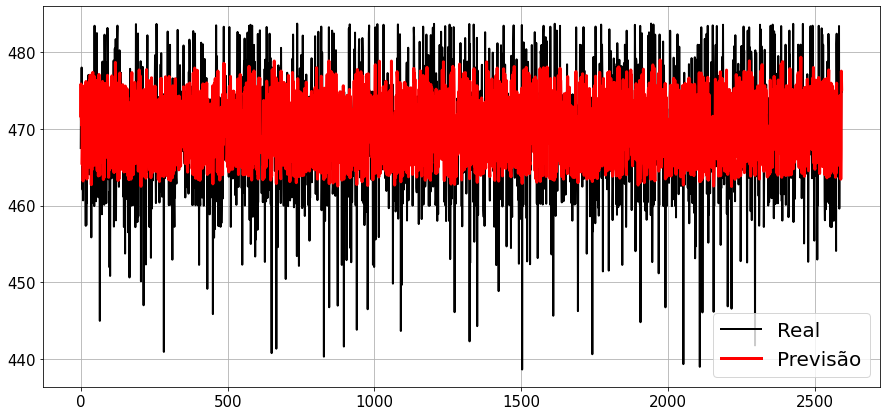

In [76]:
#figura da previsão sem incerteza associada
fig = plt.figure(figsize=(15,7))

t = np.arange(y_pred.shape[0])

plt.plot(t, yts, color="black", label="Real", lw=2)
plt.plot(t, y_pred, color='red', label="Previsão", lw=3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.grid(True)
plt.legend(fontsize=20)


#salvando figura da previsão
plt.savefig(prediction_only_path + f'graf{test_dataframe.shape[0]}.jpeg')
plt.savefig(prediction_only_path + f'graf{test_dataframe.shape[0]}.png')

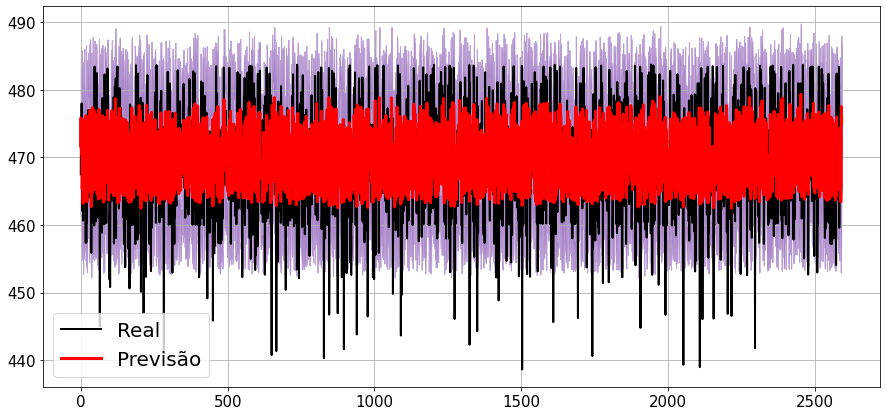

In [77]:
#figura da previsão com a adição da incerteza associada
fig2 = plt.figure(figsize=(15,7))

t = np.arange(y_pred.shape[0])

plt.plot(t, yts, color="black", label="Real", lw=2)
plt.plot(t, y_pred, color='red', label="Previsão", lw=3)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

for shade in range(1,5):
  plt.fill_between(t, y_pred[:,0]+y_inc[:,0]/2, y_pred[:,0]-y_inc[:,0]/2, alpha=0.2, color='C4')

plt.grid(True)
plt.legend(fontsize=20)

plt.savefig(prediction_with_un_path + f'graf{test_dataframe.shape[0]}.png')
plt.savefig(prediction_with_un_path + f'graf{test_dataframe.shape[0]}.jpeg')

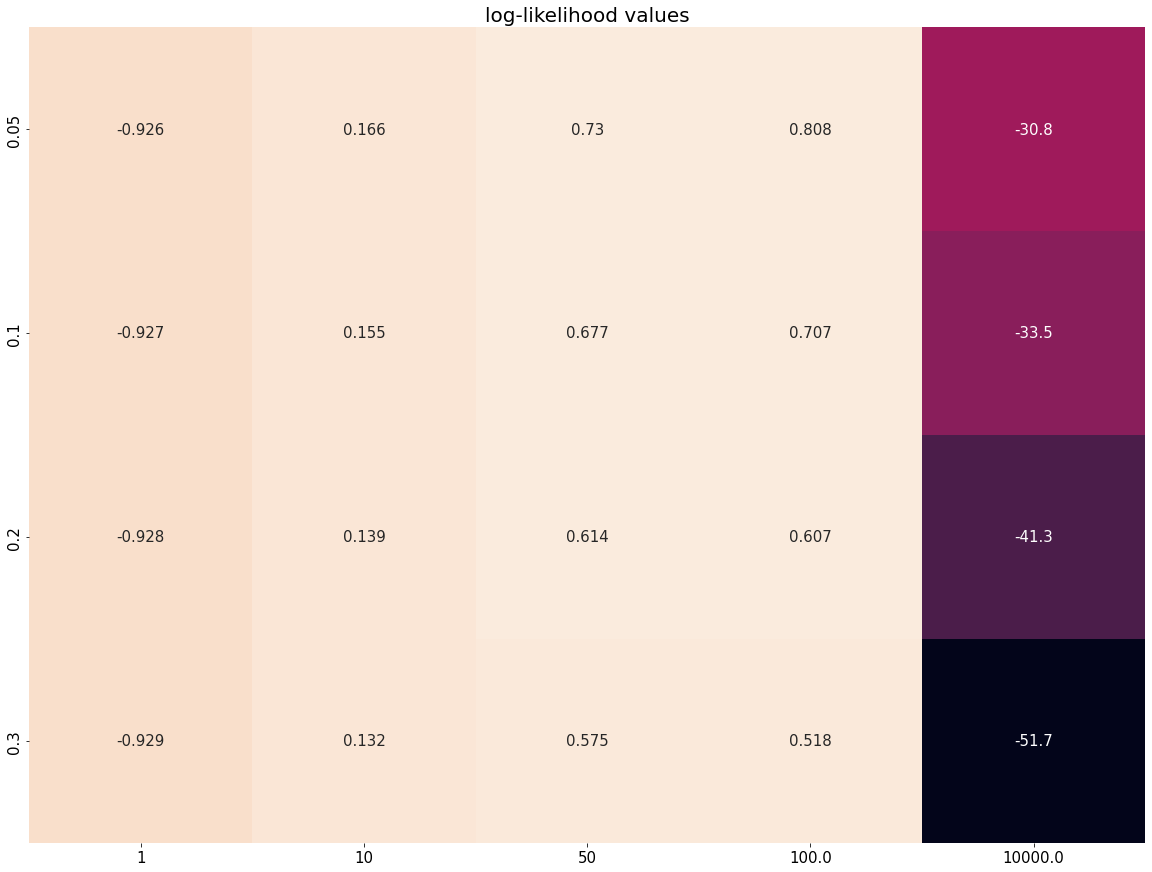

In [78]:
fig, ax = plt.subplots(figsize=(20,15))

ax.set_title("log-likelihood values", fontsize=20)
ax = sns.heatmap(list_ll, 
                 ax = ax,
                 annot=True,
                 fmt=".3g",
                 annot_kws={'size':15},
                 xticklabels=tau_values,
                 yticklabels=prob_values,
                 cbar = False)

ax.tick_params(axis='both', labelsize=15 )

fig.savefig(ll_heatmap_path + f'/graf{test_dataframe.shape[0]}.jpeg')
fig.savefig(ll_heatmap_path + f'/graf{test_dataframe.shape[0]}.png')